In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
from scipy.stats.stats import pearsonr 

In [5]:
data = pd.read_csv("Premise_Ghana_Test_Observations.csv")

#Question 1

### Part a: Identify and remove price outliers

First, to get a small sense of the data, we plot a histogram of the prices.

We see that the vast majority of prices are less than $40, and that the counts slowly decrease thereafter.

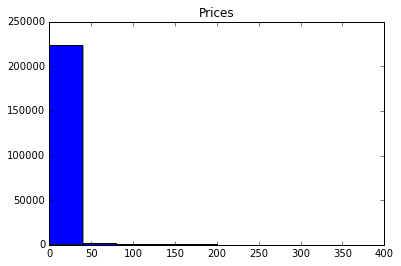

In [328]:
plt.hist(data.price)
plt.title("Prices")

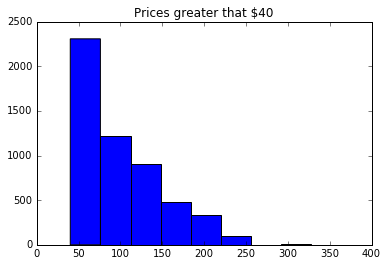

In [337]:
plt.hist(np.array(data[data.price>40].price))
plt.title("Prices greater that $40")

We now look at boxplots of the prices, broken down by product.

In [302]:
prods = np.unique(data['product_id'])
subset_prods = np.random.choice(np.unique(data['product_id']), 10)

{'boxes': [<matplotlib.lines.Line2D at 0x131bbd1d0>,
 'caps': [<matplotlib.lines.Line2D at 0x131bb2890>,
 'fliers': [<matplotlib.lines.Line2D at 0x131bcad10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x131bca510>,
 'whiskers': [<matplotlib.lines.Line2D at 0x131bbdfd0>,
  <matplotlib.lines.Line2D at 0x13229dd50>]}

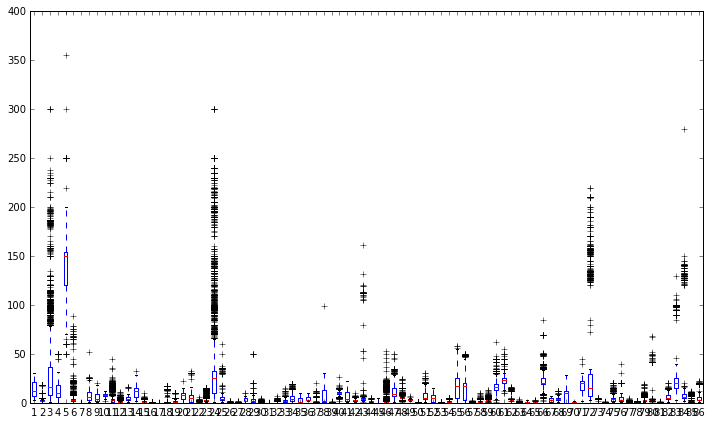

In [305]:
fig, axes = plt.subplots(figsize=(10,6), tight_layout=True)
prices = []
for prod in prods:
    prices.append(np.array(data[data.product_id==prod].price))
plt.boxplot(prices)

Now we separate based on brand, a more specific feature.

{'boxes': [<matplotlib.lines.Line2D at 0x1a1108910>,
 'caps': [<matplotlib.lines.Line2D at 0x1a5306e10>,
 'fliers': [<matplotlib.lines.Line2D at 0x151d2c990>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x151d2cdd0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a1108990>,
  <matplotlib.lines.Line2D at 0x1946ab9d0>]}

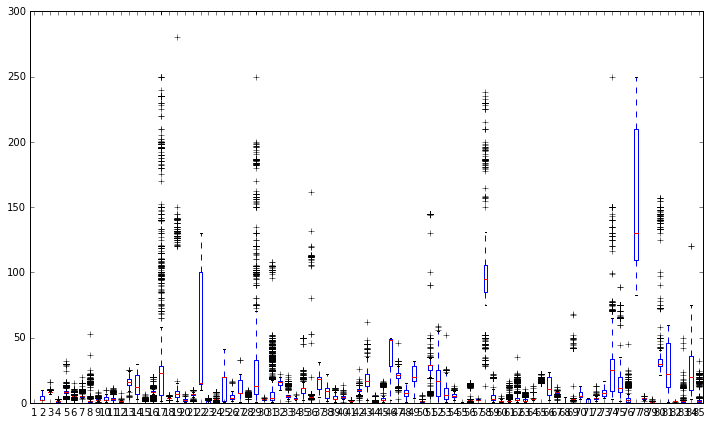

In [423]:
brands = np.unique(data['brand'])
fig, axes = plt.subplots(figsize=(10,6), tight_layout=True)
prices1 = []
for brand in brands:
    prices1.append(np.array(data[data.brand==brand].price))
plt.boxplot(prices1)

The boxplots show that simply based on the distribution prices of each product alone, we see many outliers. 

This is a start, but we are not taking into account all the other information we have. For instance, certain brands  for a product (like imported ones) might tend to be much more expensive, or hotels and other fancy places might just price things much higher. To better detect price outliers, we need to consider the brand, time, location, etc. associated with each price in our dataset. 

The interesting thing about this dataset is that all the features we would consider to find price anomalies are categorical (i.e. product, brand, store, etc.). This makes outlier detection methods such as various clustering or distance-based methods unsuitable for this dataset. Instead, section our data into clusters based on the other features as well. In essence, we simply create more boxplots, with each standing for groups with different combinations of the features (i.e. brand==Heineken and location==Carrefour). We assess the effectiveness of these cluster by looking at their sizes. 

In [316]:
# the number of data points for each product
prod_counts = data.groupby('product_id').product_name.count()
# the number of brands for each product
num_brands = data.groupby('product_id').brand.nunique()
# the count of each brand
brand_counts = data.groupby(['product_id','brand']).brand.count()

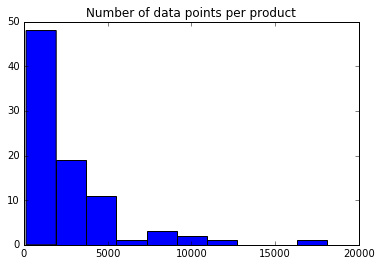

In [319]:
plt.hist(prod_counts)
plt.title("Number of data points per product")

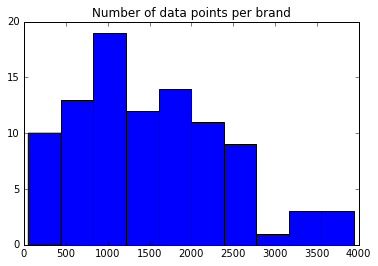

In [327]:
plt.hist(brand_counts)
plt.title("Number of data points per brand")

In [410]:
print "Size of smallest cluster:", min(brand_counts)
print "Size of largest cluster:", max(brand_counts)
print "Number of small clusters:", len(brand_counts[brand_counts<5])
print 'Number of total clusters:', len(brand_counts)

 Size of smallest cluster: 52
Size of largest cluster: 3942
Number of small clusters: 0
Number of total clusters: 95


Right now, in grouping the data points by brand, we have cluster sizes as shown in the histograms above. We add other layers to the grouping, namely the city.

{'boxes': [<matplotlib.lines.Line2D at 0x192d74ed0>,
 'caps': [<matplotlib.lines.Line2D at 0x192d68fd0>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x193807f10>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x193921e90>,
 'whiskers': [<matplotlib.lines.Line2D at 0x192d5d850>,
  ...]}

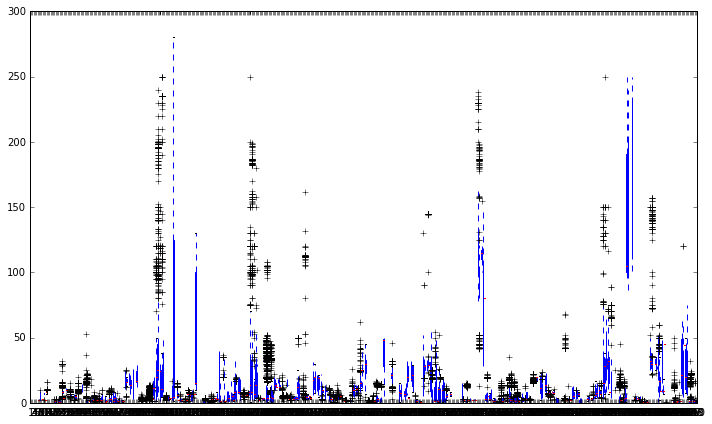

In [424]:
cities = np.unique(data.city)
fig, axes = plt.subplots(figsize=(10,6), tight_layout=True)
prices2 = [np.array(data[(data.brand==brand) & (data.city==city)].price) for brand in brands for city in cities]
plt.boxplot(prices2)

Here we see far fewer outliers than before. This makes sense as some of the extreme values have been accounted for with the new information for the city. 


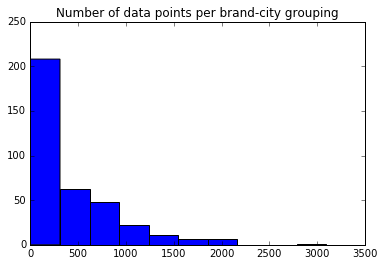

In [385]:
brand_city_counts = data.groupby(['brand','city']).price.count()
plt.hist(brand_city_counts)
plt.title("Number of data points per brand-city grouping")

In [407]:
print "Size of smallest cluster:", min(brand_city_counts)
print "Size of largest cluster:", max(brand_city_counts)
print "Number of small clusters:", len(brand_city_counts[brand_city_counts<5])
print 'Number of total clusters:', len(brand_city_counts)

Size of largest cluster: 3092
Number of small clusters: 57
Number of total clusters: 364


We add one more layer to make the clustering groups even smaller. Here we add month.

{'boxes': [<matplotlib.lines.Line2D at 0x1fd9dee50>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x1fd87e350>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x1fd872990>,
  ...],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1fd872250>,
  ...],
 'whiskers': [<matplotlib.lines.Line2D at 0x14914d310>,
  ...]}

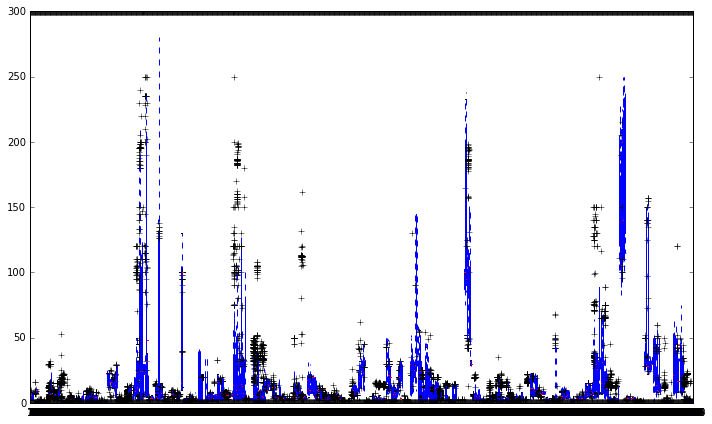

In [499]:
months = np.unique(data.month)
fig, axes = plt.subplots(figsize=(10,6), tight_layout=True)
prices3 = [np.array(data[(data.brand==brand) & (data.city==city) & (data.month==month)].price) 
          for brand in brands for city in cities for month in months]
# clean prices3 to get rid of nonexisting grouping combinations
price_final = [price for price in prices3 if price.any()]
plt.boxplot(price_final)

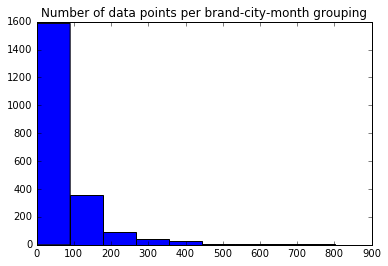

In [398]:
brand_city_month_counts = data.groupby(['brand','city','month']).price.count()
plt.hist(brand_city_month_counts)
plt.title("Number of data points per brand-city-month grouping")

In [408]:
print "Size of smallest cluster:", min(brand_city_month_counts)
print "Size of largest cluster:", max(brand_city_month_counts)
print "Number of small clusters:", len(brand_city_month_counts[brand_city_month_counts<5])
print 'Number of total clusters:', len(brand_city_month_counts)

Size of smallest cluster: 1
Size of largest cluster: 890
Number of small clusters: 340
Number of total clusters: 2119


Now we get the actual outliers. If we wanted to, we could also retrieve them back from  the original data frame. This would allow us to remove outliers from the data before our analyses as well as look more closely at these outliers themselves. Here, however, we just look at the price, brand, city, and month of the outliers.

In [490]:
import math
def get_outlier_prices(cluster):
    """ get the outlier price values """
    # If the cluster size is smaller than 5, ignore
    # Too few points to determine whether any would be an outlier
    if len(cluster)<5:
        outliers = None
        non_outliers = cluster
    
    else:
        cluster = sorted(cluster)
        length = len(cluster)
        quart3 = cluster[int(math.ceil(length*3/4.)) - 1]
        quart1 = cluster[int(math.floor(length* 1/4.)) - 1]
        iqr = quart3 - quart1
        # Determined to be an outlier if more than 3 times the interquartile range away from the nearest quartile
        outliers = [el for el in cluster if (el > quart3 + iqr) or (el < quart1 - iqr)]
        if len(outliers)==0:
            outliers = None
        non_outliers = [el for el in cluster if (el <= quart3 + iqr) and (el >= quart1 - iqr)]
    
    return (outliers, non_outliers)

In [480]:
# create a dataframe of the brand-city-month combinations
brand_city_month = brand_city_month_counts.reset_index()
# check that the shapes correspond
print len(price_final)
print brand_city_month.shape

2119
(2119, 4)


In [491]:
# add a column for price outliers
brand_city_month['price_outliers'] = [get_outlier_prices(price)[0] for price in price_final]
brand_city_month['price_non_outliers'] = [get_outlier_prices(price)[1] for price in price_final]

In [492]:
brand_city_month.head()

,brand,city,month,price,price_outliers,price_non_outliers
0,Africa Queen,Accra,04,1,None,[3.0]
1,Africa Queen,Accra,07,17,"[2.0, 3.0]","[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, ..."
2,Africa Queen,Kumasi,01,10,[10.0],"[2.0, 2.0, 2.0, 2.0, 2.20000004768, 2.20000004..."
3,Africa Queen,Kumasi,02,15,[8.0],"[2.0, 2.0, 2.20000004768, 2.20000004768, 2.200..."
4,Africa Queen,Kumasi,03,21,None,"[2.0, 2.09999990463, 2.20000004768, 2.20000004..."


In [497]:
# remove groupings without outliers
outlier_df = brand_city_month[~brand_city_month.price_outliers.isnull()]
outlier_df.shape

(1040, 6)

In [496]:
outlier_df.columns = ['brand','city','month','num_items','outliers','non-outliers']
outlier_df.head()

,brand,city,month,num_items,outliers,non-outliers
1,Africa Queen,Accra,07,17,"[2.0, 3.0]","[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, ..."
2,Africa Queen,Kumasi,01,10,[10.0],"[2.0, 2.0, 2.0, 2.0, 2.20000004768, 2.20000004..."
3,Africa Queen,Kumasi,02,15,[8.0],"[2.0, 2.0, 2.20000004768, 2.20000004768, 2.200..."
5,Africa Queen,Kumasi,04,17,"[2.0, 2.5, 2.5, 2.5]","[2.20000004768, 2.20000004768, 2.20000004768, ..."
6,Africa Queen,Kumasi,05,47,"[8.0, 8.0, 8.0, 8.0, 8.0, 8.0]","[1.89999997616, 1.89999997616, 1.89999997616, ..."


From this subset of the dataframe, we see that the method of choosing outliers is probably not optimal, especially as the small size of the groupings means there is less variance overall, making even small variances come off as outliers. A next step could be to do a similar analysis with the less granular groupings. For more discussion about improving the outlier detection, see part c.

### Part b: Plot outliers

Please refer to the boxplots above for plots of the outliers. With more time, I would zoom in on these plots and create labels for the cluster identifications for ease of interpretation. I would also play around with scatter plots using the outlier_df dataframe created at the end. 

### Part c: Self-access outlier detection

The nature of the data made outlier detection a very interesting problem, and while I began to explore methods beyond simply taking prices beyond the 3 standard deviation mark, there is still much more that could be done. For example, instead of treating the non-price variables as unordered, categorical variables, I could order them based on the average prices for each factor value. For instance, if Accra on average saw higher prices than Kumasi, I could assign Accra to a higher order or a higher number, taking into account distances between the averages. By integrating this extra information, I could perhaps create a more precise outlier detection method. Additionally, I could experiment with other types of methods that are used for quantitative variables that I did not explore here, such as various clustering and distance-based methods. 

#Question 2

### Part a: Find average number of unique places

In [242]:
users = data.groupby('user_id')
unique_places_per_user = users.place_id.nunique().mean()
unique_places_per_user 

32.503999999999998

Note: we ignore NaNs for simplicity. 

### Part b: Find average number of unique products during highest value month

In [28]:
def find_month(timestamp):
    """ find the month from the timestamp """
    try:
        start = timestamp.index('-') + len('-')
        end = timestamp.index('-', start)
        return timestamp[start:end]
    except ValueError:
        return ""

In [26]:
data['month'] = data['timestamp'].apply(find_month)

In [167]:
# data grouped by user and month
group_user_month = data.groupby(['user_id','month'], sort=True)
# number of unique products for each user per month
unique_prods_per_user_month = group_user_month.product_id.nunique()
# unique_prods_per_user_month as a dataframe
df_grouped = unique_prods_per_user_month.reset_index()
# average number of unique products in the highest month
avg_unique_prods_highest_month = df_grouped.groupby('user_id').product_id.max().mean()
avg_unique_prods_highest_month 

22.856000000000002

In [243]:
avg_unique_prods_per_user = users.product_id.nunique().mean()
avg_unique_prods_per_user

24.440000000000001

The average number of unique products gathered by users during their highest month is pretty close to the average number of products. We hypothesize that this is a result of most people collecting the majority of their total data inthe course of one month, and we dive into the data to confirm/reject the hypothesis.

We see that the distribution of the number of unique products is pretty similar for users on teir highest month versus overall.

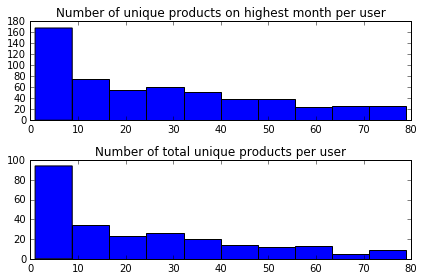

In [168]:
fig, ax = plt.subplots(2,1,tight_layout=True)
ax[0].hist(group_user_month.product_id.nunique())
ax[0].set_title("Number of unique products on highest month per user")
ax[1].hist(df_grouped.groupby('user_id').product_id.max())
ax[1].set_title("Number of total unique products per user")

Second, we see that most users gather their information within the course of a month.

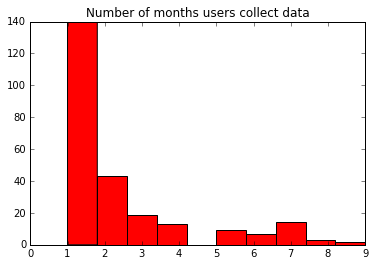

In [176]:
plt.hist(df_grouped.groupby('user_id').month.count(),color='red')
plt.title("Number of months users collect data")

Finally, we now take a look of the breakdown of unique products per month for a random subset of users. We see that, that, amongst those who collect data for more thn one month, a large subset also gather most of their total in the course of one month.

In [169]:
subset_users = np.random.choice(np.unique(data['user_id']), 20)

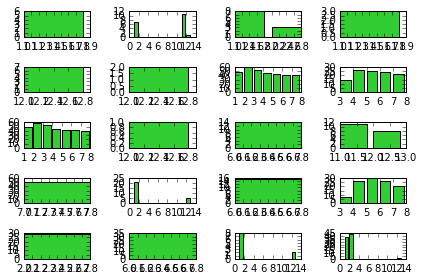

In [173]:
fig1, axes = plt.subplots(5,4,tight_layout=True)
for index, user in enumerate(subset_users):
    ax1 = axes[index/4,index%4]
    ax1.bar(df_grouped[df_grouped.user_id==user].month, 
        df_grouped[df_grouped.user_id==user].product_id,color='limegreen')

These findings confirm our hypothesis.

### Part c: Find correlation between number of observations and time between the first and last

In [238]:
# convert to datetime object
datetime_dates = dates.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))

In [239]:
data['date'] = datetime_dates

In [244]:
# get total number of products per user
prods_users = users.product_id.nunique()
# get time period of user activity
time_period = users.apply(lambda x: x.date.max() - x.date.min())
# convert timedelta to int
time_period = (time_period/ np.timedelta64(1, 'D')).astype(int)

In [260]:
# get the correlation
pearsonr(prods_users, time_period)[0]

0.62981338246031049